In [1]:
import pandas as pd
import numpy as np
import kagglehub
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from  sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

/home/dustinvan/WORK/Summer-2025-ECE-597-Group1/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data loaded successfully.
Dataset shape before cleaning: (164972, 2)
Dataset shape after cleaning: (164552, 2)
Class distribution:


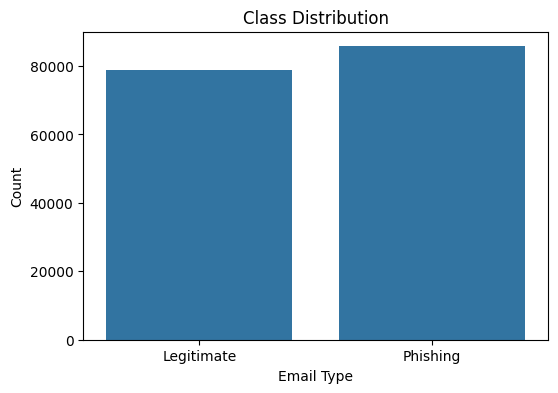

,text,label
0,"Never agree to be a loser Buck up, your troubl...",1
1,Befriend Jenna Jameson \nUpgrade your sex and ...,1
2,CNN.com Daily Top 10 >+=+=+=+=+=+=+=+=+=+=+=+=...,1
3,Re: svn commit: r619753 - in /spamassassin/tru...,0
4,SpecialPricesPharmMoreinfo \nWelcomeFastShippi...,1


In [2]:
# Download Dataset
path = kagglehub.dataset_download("naserabdullahalam/phishing-email-dataset")
# Load the dataset
df1 = pd.read_csv(path + "/CEAS_08.csv")
df2 = pd.read_csv(path + "/Nazario.csv")
df3 = pd.read_csv(path + "/Nigerian_Fraud.csv")
df4 = pd.read_csv(path + "/SpamAssasin.csv")
df5 = pd.read_csv(path + "/Enron.csv")
df6 = pd.read_csv(path + "/Ling.csv")
df7 = pd.read_csv(path + "/phishing_email.csv")
print("Data loaded successfully.")

# Reformat the datasets to have consistent columns and combine them
df_group1 = pd.concat([df1, df2, df3, df4], ignore_index=True)
df_group1['text'] = df_group1['subject'].fillna('') + ' ' + df_group1['body'].fillna('')
df_group1 = df_group1[['text', 'label']]
# Display the first few rows of the combined DataFrame



# Rename columns for consistency
for df_temp in [df5, df6]:
    df_temp['text'] = df_temp['subject'].fillna('') + ' ' + df_temp['body'].fillna('')
df5 = df5[['text', 'label']]
df6 = df6[['text', 'label']]

df7.rename(columns={'text_combined': 'text'}, inplace=True)

df = pd.concat([df_group1, df5, df6, df7], ignore_index=True)
df.head()
print(f"Dataset shape before cleaning: {df.shape}")

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

df.dropna(inplace=True)

# remove duplicate rows
df.drop_duplicates(inplace=True)

# reset index after dropping rows
df.reset_index(drop=True, inplace=True)

print(f"Dataset shape after cleaning: {df.shape}")
# Visualize the class distribution
print("Class distribution:")

plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df)
plt.title('Class Distribution')
plt.xticks([0,1], ['Legitimate', 'Phishing'])
plt.xlabel('Email Type')
plt.ylabel('Count')
plt.show()

df.head()

In [3]:
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove URLs
    # text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove stop words
    text = ' '.join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])

    return text

df['text'] = df['text'].apply(preprocess_text)
print("Text preprocessing completed.")

Text preprocessing completed.


In [4]:
df.info()

vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(1,1))
bow = CountVectorizer(max_features=5000,ngram_range=(1,1))

X_tfidf_5000 = vectorizer.fit_transform(df['text'])
X_bow_5000 = bow.fit_transform(df['text'])
y = df['label'].values

X_tfidf_5000_train, X_tfidf_5000_test, y_train, y_test = train_test_split(X_tfidf_5000, y, test_size=0.2, random_state=42, stratify=y)
X_bow_5000_train, X_bow_5000_test = train_test_split(X_bow_5000, test_size=0.2, random_state=42, stratify=y)
print(f"Training set shape: {X_tfidf_5000_train.shape}, Testing set shape: {X_tfidf_5000_test.shape}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164552 entries, 0 to 164551
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    164552 non-null  object
 1   label   164552 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.5+ MB
Training set shape: (131641, 5000), Testing set shape: (32911, 5000)


In [10]:
# Using TF-IDF approach
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create a pipeline with Random Forest classifier
pipeline = Pipeline([
    ('classifier', RandomForestClassifier())
])

# Define parameter grid for TF-IDF approach
param_grid = {
    'classifier__n_estimators': [25, 50],
    'classifier__max_depth': [20, 30],
    'classifier__min_samples_split': [2, 4],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt']
}

# Perform Grid Search with 5-fold cross-validation for TF-IDF
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)
train_data = X_tfidf_5000_train
test_data = X_tfidf_5000_test

# Fit the grid search
print("Performing Grid Search with TF-IDF approach...")
grid_search.fit(train_data, y_train)

import pandas as pd
results_df = pd.DataFrame(grid_search.cv_results_)
print("\nResults as DataFrame:")
print(results_df)
print(grid_search.best_params_)

# Get the best model
best_model_tfidf = grid_search.best_estimator_


Performing Grid Search with TF-IDF approach...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=25; total time=  19.0s
[CV] END classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=25; total time=  20.8s
[CV] END classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=25; total time=  21.1s
[CV] END classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=25; total time=  21.2s
[CV] END classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=25; total time=  22


Test Set Accuracy: 0.9487

Classification Report:
              precision    recall  f1-score   support

           0     0.9926    0.8997    0.9439     15765
           1     0.9151    0.9938    0.9528     17146

    accuracy                         0.9487     32911
   macro avg     0.9538    0.9468    0.9484     32911
weighted avg     0.9522    0.9487    0.9485     32911



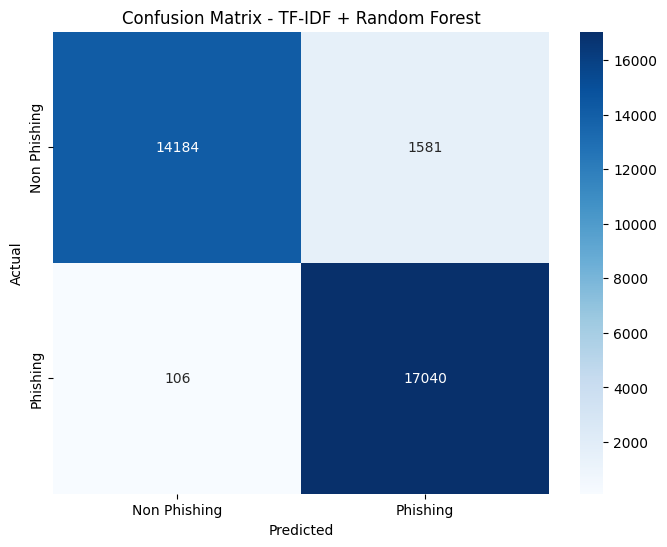


AUC Score: 0.9934


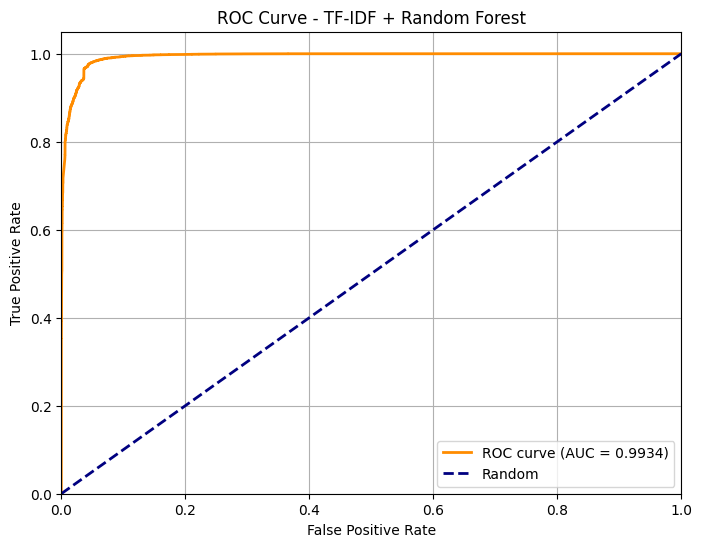

In [19]:

# Make predictions on test set
y_pred_tfidf = best_model_tfidf.predict(test_data)

# Calculate accuracy
model_accuracy = accuracy_score(y_test, y_pred_tfidf)
print(f"\nTest Set Accuracy: {model_accuracy:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tfidf, digits=4))

# Create confusion matrix for TF-IDF
plt.figure(figsize=(8, 6))
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf)
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non Phishing', 'Phishing'],
            yticklabels=['Non Phishing', 'Phishing'])
plt.title('Confusion Matrix - TF-IDF + Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate AUC score
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get prediction probabilities for AUC calculation
y_pred_proba_tfidf = best_model_tfidf.predict_proba(test_data)[:, 1]

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred_proba_tfidf)
print(f"\nAUC Score: {auc_score:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_tfidf)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - TF-IDF + Random Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [15]:
# Using bag of words approach
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create a pipeline with CountVectorizer (Bag of Words) and Random Forest
pipeline = Pipeline([
    ('classifier', RandomForestClassifier())
])

# Define parameter grid for Bag of Words approach
param_grid = {
    'classifier__n_estimators': [25, 50],
    'classifier__max_depth': [20, 30],
    'classifier__min_samples_split': [2, 4],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt']
}

# Perform Grid Search with 5-fold cross-validation for Bag of Words
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)
train_data = X_bow_5000_train
test_data = X_bow_5000_test

# Fit the grid search
print("Performing Grid Search with Bag of Words approach...")
grid_search.fit(train_data, y_train)

import pandas as pd
results_df = pd.DataFrame(grid_search.cv_results_)
print("\nResults as DataFrame:")
print(results_df)
print(grid_search.best_params_)

# Get the best model
best_model_bow = grid_search.best_estimator_


Performing Grid Search with Bag of Words approach...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=25; total time=  12.8s
[CV] END classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=25; total time=  13.2s
[CV] END classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=25; total time=  13.7s
[CV] END classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=25; total time=  13.9s
[CV] END classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=25; total tim


Test Set Accuracy: 0.9589

Classification Report:
              precision    recall  f1-score   support

           0     0.9918    0.9217    0.9555     15765
           1     0.9324    0.9930    0.9618     17146

    accuracy                         0.9589     32911
   macro avg     0.9621    0.9574    0.9586     32911
weighted avg     0.9609    0.9589    0.9588     32911



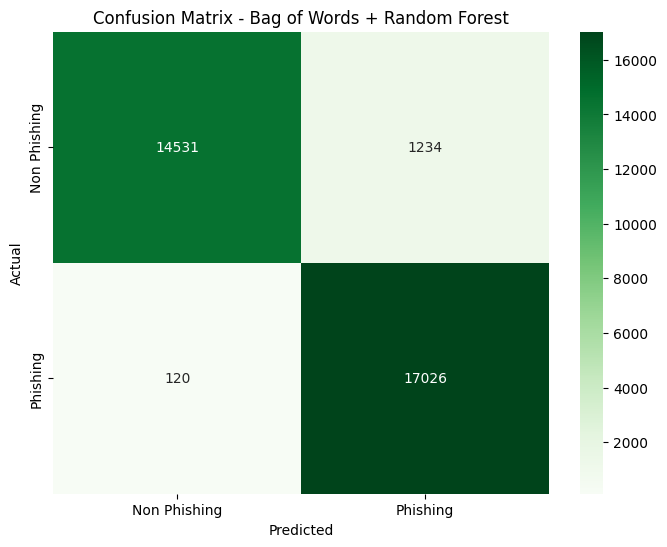


AUC Score: 0.9950


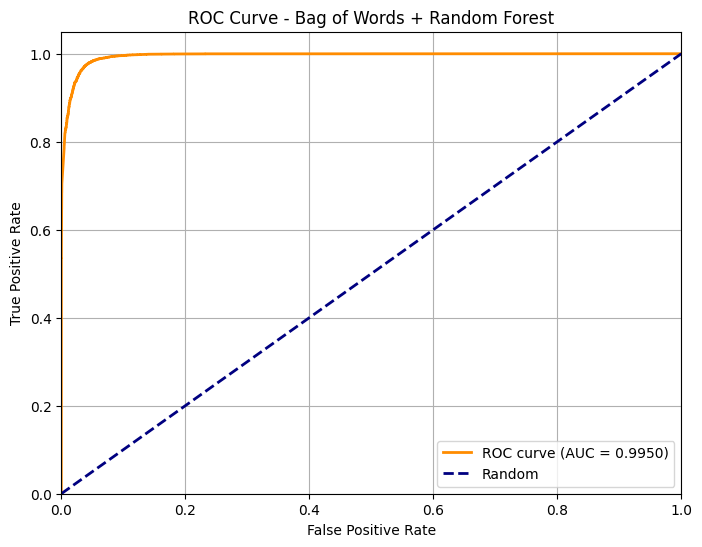

In [17]:

# Make predictions on test set
y_pred_bow = best_model_bow.predict(test_data)

# Calculate accuracy
model_accuracy = accuracy_score(y_test, y_pred_bow)
print(f"\nTest Set Accuracy: {model_accuracy:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_bow, digits=4))

# Create confusion matrix for Bag of Words
plt.figure(figsize=(8, 6))
cm_bow = confusion_matrix(y_test, y_pred_bow)
sns.heatmap(cm_bow, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Non Phishing', 'Phishing'],
            yticklabels=['Non Phishing', 'Phishing'])
plt.title('Confusion Matrix - Bag of Words + Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Calculate AUC score
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get prediction probabilities for AUC calculation
y_pred_proba_bow = best_model_bow.predict_proba(test_data)[:, 1]

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred_proba_bow)
print(f"\nAUC Score: {auc_score:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_bow)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Bag of Words + Random Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

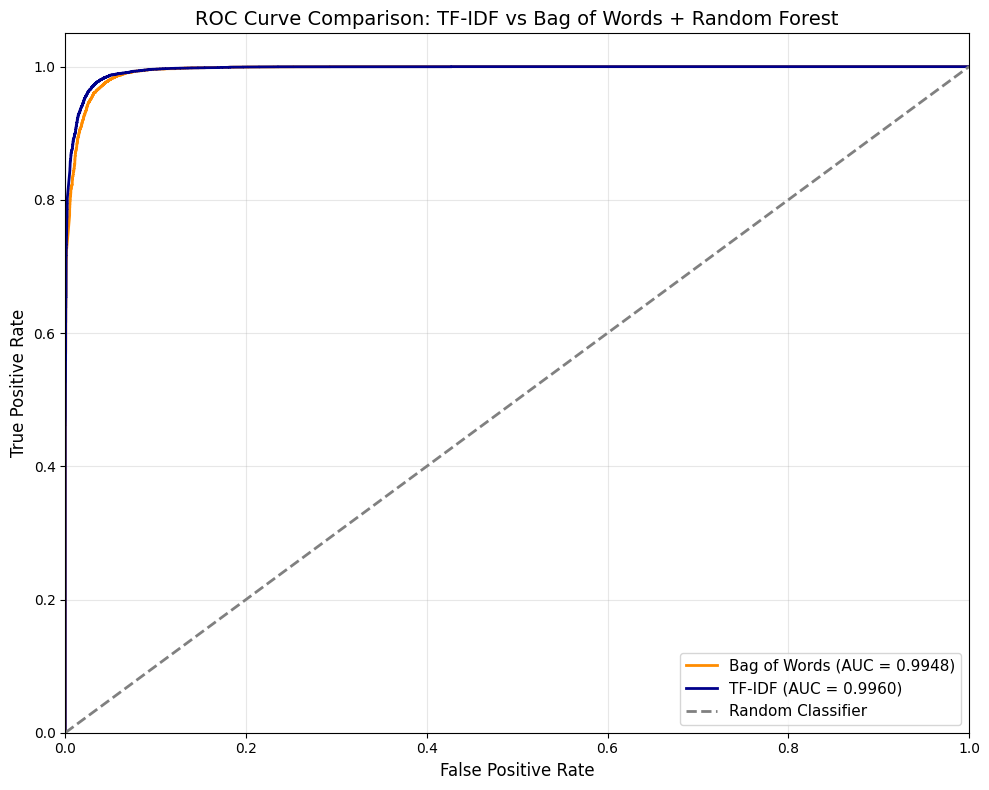

Bag of Words AUC Score: 0.9948
TF-IDF AUC Score: 0.9960
Difference: 0.0012


In [20]:
# Compare ROC curves for both TF-IDF and Bag of Words models
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get prediction probabilities for both models
y_pred_proba_bow = best_model.predict_proba(X_bow_5000_test)[:, 1]
y_pred_proba_tfidf = best_model_tfidf.predict_proba(X_tfidf_5000_test)[:, 1]

# Calculate AUC scores
auc_bow = roc_auc_score(y_test, y_pred_proba_bow)
auc_tfidf = roc_auc_score(y_test, y_pred_proba_tfidf)

# Calculate ROC curves
fpr_bow, tpr_bow, _ = roc_curve(y_test, y_pred_proba_bow)
fpr_tfidf, tpr_tfidf, _ = roc_curve(y_test, y_pred_proba_tfidf)

# Plot comparison ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr_bow, tpr_bow, color='darkorange', lw=2, 
         label=f'Bag of Words (AUC = {auc_bow:.4f})')
plt.plot(fpr_tfidf, tpr_tfidf, color='darkblue', lw=2, 
         label=f'TF-IDF (AUC = {auc_tfidf:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', 
         label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison: TF-IDF vs Bag of Words + Random Forest', fontsize=14)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Bag of Words AUC Score: {auc_bow:.4f}")
print(f"TF-IDF AUC Score: {auc_tfidf:.4f}")
print(f"Difference: {abs(auc_tfidf - auc_bow):.4f}")
